In [27]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [28]:
def calculate_fitness(agent):
    x, y = agent[0], agent[1]
    return np.sin(x/100) * np.sin(y/100) * 1.5 ** (x/250) * 1.5 ** (y/250)

In [112]:
def sine(x, period=100, offset=0, max=1):
    x = x+offset
    return (np.sin(2*x*np.pi/period)/2 + 0.5) * max

def sawtooth(x, period=100, offset = 0, max=1):
    x = x+offset
    return ((x%period)/period) * max

def exponentialsawtooth(x, period=100, offset = 0, exponent=2, max=1):
    x = x+offset
    return (((x%period)/period) ** exponent) * max

def exponentialsine(x, period=100, offset = 0, exponent=2, max=1):
    x = x+offset
    return ((np.sin(2*x*np.pi/period)/2 + 0.5) ** exponent) * max

In [181]:
def calculate_fitness_array(agents):
    fitnesses = np.array([calculate_fitness(agent) for agent in agents])
    return fitnesses

def calculate_reproduction_chance(agents, epoch=1, value_uniqueness = 0.5):
    fitnesses = calculate_fitness_array(agents)
    fitnesses = (fitnesses-np.mean(fitnesses))/np.std(fitnesses)
    
    if value_uniqueness:
        gene_uniqueness = np.array([distance(np.mean(agents, axis=0), agent) for agent in agents])
        gene_uniqueness = (gene_uniqueness-np.mean(agents))/np.std(gene_uniqueness)

        reproduction_chance = fitnesses + (gene_uniqueness * value_uniqueness)
        reproduction_chance = (reproduction_chance-np.mean(reproduction_chance))/np.std(reproduction_chance)

        return reproduction_chance+2
    
    return fitnesses+2

def distance(x1, x2):
    return np.linalg.norm(x1-x2)

def mutate_agent(agent, rate, bounds):
    
    if rate < 1/1000000:
        return agent
    
    mutations = np.random.uniform(0,1/rate, size=agent.shape)
    mutations[mutations>1] = 0
    
    agent[mutations!=0] += np.random.normal(0, (bounds[1]-bounds[0]) ** 0.4, mutations[mutations!=0].shape).astype(np.int32)
    agent[agent<bounds[0]] = bounds[0]
    agent[agent>bounds[1]] = bounds[1]
    
    return agent

def mutate_array(agents, rate, bounds):
    mutated_agents = np.array([mutate_agent(agent, rate, bounds) for agent in agents])
    return mutated_agents

def merge_genes(a, b, n_genes):
    merged = np.zeros(shape=(n_genes, int(a.shape[0]/n_genes)))
    
    genes_a = a.reshape(n_genes, int(a.shape[0]/n_genes))
    genes_b = b.reshape(n_genes, int(b.shape[0]/n_genes))
    to_merge = np.random.randint(0,2, size=(n_genes))

    merged[to_merge == 0] = genes_a[to_merge == 0]
    merged[to_merge == 1] = genes_b[to_merge == 1]
    
    return merged.reshape(-1)

def genes_to_rgb(agent):
    RGB_driver = agent.reshape(8, 3, int(agent.shape[0]/24))
    image_pixels = np.zeros(shape=(1, int(agent.shape[0]/24), 3))
    for i, pixel in enumerate(RGB_driver):
        for j, channel in enumerate(pixel):
            image_pixels[0][i][j] = channel.dot(2**np.arange(channel.size)[::-1])
    return image_pixels.astype(int)

def show_n_agents(agents, n):
    fig, ax = plt.subplots(round(n/8),8,figsize=(12,6))
    img = []
    indices = np.random.randint(0,agents.shape[0], size=(n))
    for i, index in enumerate(indices):
        ax[i].imshow(agents[index].reshape(10,10), cmap='plasma', vmin=agent_bounds[0], vmax=agent_bounds[1])
        ax[i].axis('off')
        
def calculate_entropy(agents):
    entropy = np.zeros(agents.shape[1])
    for col in range(agents.shape[1]):
        unique, counts = np.unique(agents[:,col], return_counts=True)
        for i, count in enumerate(counts):
            entropy[col] += (count/np.sum(counts) * (np.sum(counts) - count)/np.sum(counts))
    return np.mean(entropy)

def next_generation(agents, generation=0, mutation_rate=0.01, value_diversity = 0.5, num_chromosomes = 10):
    
    fitnesses = calculate_reproduction_chance(agents, epoch=i, value_uniqueness=value_diversity)
    gene_pool = np.array(random.choices(current_generation, weights = fitnesses, k=current_generation.shape[0]*2))
    
    next_generation = np.array([merge_genes(gene_pool[i], gene_pool[i+1], num_chromosomes) for i in range(int(len(gene_pool)/2))])
    next_generation = mutate_array(next_generation, mutation_rate, agent_bounds)
    return next_generation

def save_n_agents_img(agents, epoch):
    fig, ax = plt.subplots(1,1,figsize=(8, 8))
    ax.imshow(z, cmap='plasma')
    ax.axis('off')
    ax.scatter(agents[:,0], agents[:,1], s=5, color='black', alpha=0.5);
    
    fig.savefig(f'Output/{str(epoch).zfill(5)}.jpg')
    plt.close(fig)

In [198]:
num_genes = 2 
num_agents = 100
num_generations = 1000
num_chromosomes = 1
mutation_rate = 0.5
starting_bounds = (50,150)
agent_bounds = (0,1000) #Inclusive

In [199]:
current_generation = np.random.randint(starting_bounds[0], starting_bounds[1]+1, size=(num_agents, num_genes))
first_generation = np.copy(current_generation)
history = []
genetic_diversity = []

In [200]:
current_generation.shape

(100, 2)

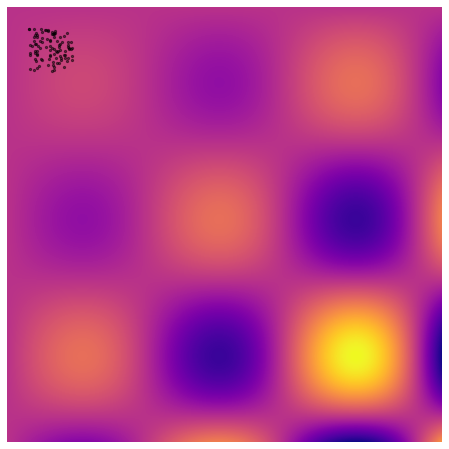

In [201]:
x = np.arange(0,1000,1)
y = np.arange(0,1000,1)
X,Y = np.meshgrid(x,y)
z = np.sin(X/100) * np.sin(Y/100) * 1.5 ** (X/250) * 1.5 ** (Y/250)

fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax.imshow(z, cmap='plasma')
ax.axis('off')
ax.scatter(current_generation[:,0], current_generation[:,1], s=5, color='black', alpha=0.5);

In [202]:
for i in range(num_generations):
    gen_mutation_rate = sine(i, period=125, max=mutation_rate, offset = -25)
    uniqueness_value = exponentialsine(i, period=400, exponent=4, max=1.25, offset = 100)
    
    current_generation = next_generation(current_generation, generation=i, mutation_rate=mutation_rate, value_diversity = uniqueness_value, num_chromosomes = num_chromosomes)
    
    history.append(np.mean([calculate_fitness(agent) for agent in current_generation])/num_genes)
    genetic_diversity.append(np.mean([distance(np.mean(current_generation, axis=0), agent) for agent in current_generation]))
    
    save_n_agents_img(current_generation, i)

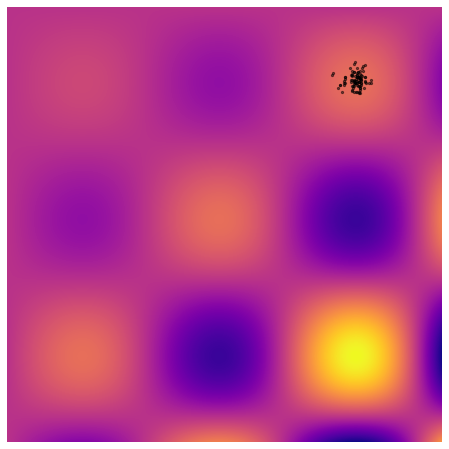

In [204]:
x = np.arange(0,1000,1)
y = np.arange(0,1000,1)
X,Y = np.meshgrid(x,y)
z = np.sin(X/100) * np.sin(Y/100) * 1.5 ** (X/250) * 1.5 ** (Y/250)

fig, ax = plt.subplots(1,1,figsize=(8, 8))
ax.imshow(z, cmap='plasma')
ax.axis('off')
ax.scatter(current_generation[:,0], current_generation[:,1], s=5, color='black', alpha=0.5);

Final diversity score: 19.678663351376183


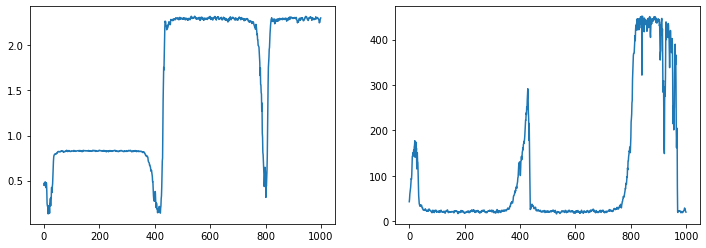

In [205]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(np.arange(0, len(history)), history)
ax[1].plot(np.arange(0, len(genetic_diversity)), genetic_diversity)
print(f'Final diversity score: {genetic_diversity[-1]}')

In [17]:
current_generation.shape

(100, 100)